In [1]:
import torchvision , torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from rcnn_transfrom import InterpolationTransform as it

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cuda:0'
num_classes = 2

def get_instance_segmentation_model(num_classes,pretrained=True,mode='bilinear'):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    model.transform = it(min_size=(800,), max_size=1333,image_mean=[0.485, 0.456, 0.406],image_std=[0.229, 0.224, 0.225],mode=mode)
    return model

### About model 

In [7]:
# number of  parameters
bicubic_m = get_instance_segmentation_model(num_classes,pretrained=False,mode='bicubic')
bicubic_m.to(device)
m_path = './model/pf_4_bicubic.pth'
bicubic_pter = torch.load(m_path)

bicubic_m.load_state_dict(bicubic_pter['model_state_dict'])

import torch
sp = torch.rand(1,3,300,400,device='cuda:0')
bicubic_m.eval()
# bicubic_m(sp)

from torchinfo import summary 
summary(bicubic_m)

### training info 

#### pennFudan 

In [2]:
bicubic_m = get_instance_segmentation_model(num_classes,pretrained=False,mode='bicubic')
bicubic_m.to(device)
m_path = './model/pf_4_bicubic.pth'
bicubic_pter = torch.load(m_path)
# bicubic_m.eval()
# bicubic_m.load_state_dict(bicubic_pter['model_state_dict'])

nearest_m = get_instance_segmentation_model(num_classes,pretrained=False,mode='nearest')
nearest_m.to(device)
m_path = './model/pf_4_nearest.pth'
nearest_pter = torch.load(m_path)
# nearest_m.eval()
# nearest_m.load_state_dict(nearest_pter['model_state_dict'])

device = 'cuda:1'
bilinear_m    = get_instance_segmentation_model(num_classes,pretrained=False,mode='bilinear')
bilinear_m.to(device)
m_path        = './model/pf_4_bilinear.pth'
bilinear_pter = torch.load(m_path)
# bilinear_m.eval()
# bilinear_m.load_state_dict(bilinear_pter['model_state_dict'])

bicubic_evals  = bicubic_pter['evaluators']
nearest_evals  = nearest_pter['evaluator']
bilinear_evals = bilinear_pter['evaluators']

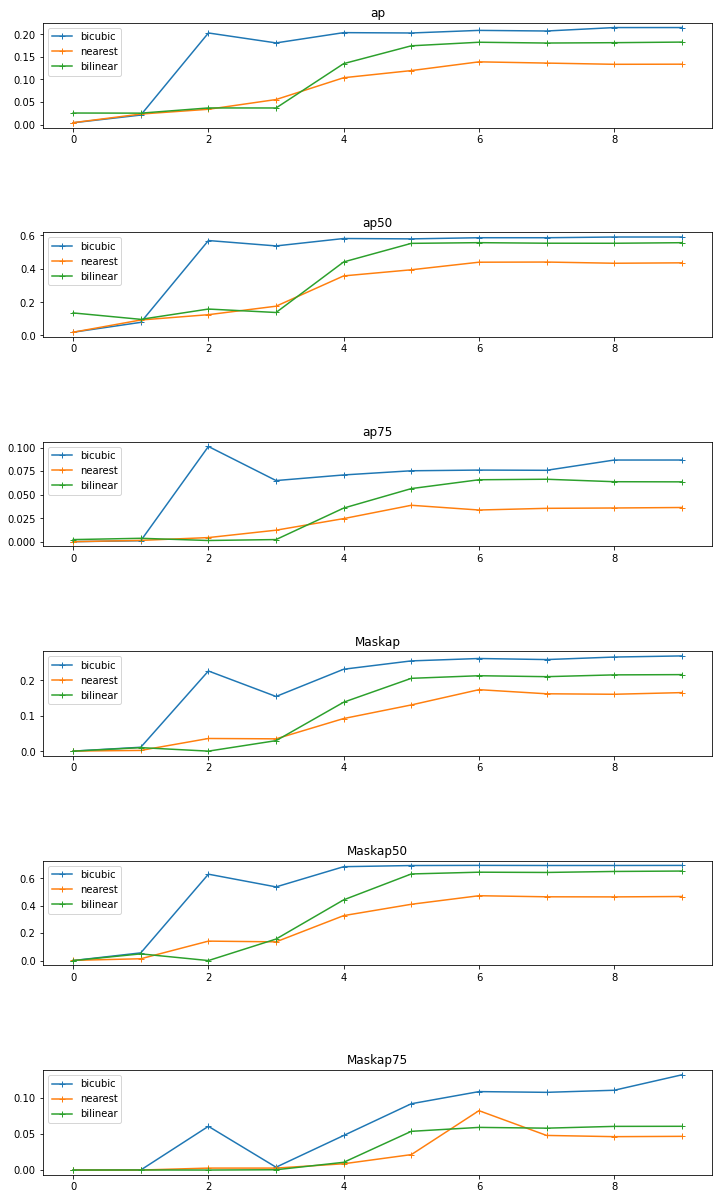

In [14]:
from matplotlib import pyplot as plt
interpols = ['bicubic','nearest','bilinear']
metric_name   = ['ap','ap50','ap75','Maskap','Maskap50','Maskap75']
num_metric    = len(metric_name)
limit         = 10
f, axs = plt.subplots(num_metric, 1, figsize=(12, 20),sharex=False) # w,h

for inter in interpols:
    exec(f'evaluators={inter}_evals')
    
    metrics = dict(zip( metric_name, list( [] for _ in range(len(metric_name))  )  
                      ))

    for evtor in evaluators:
        for iou_type, coco_eval in evtor.coco_eval.items():
            #coco_eval.summarize()
            #  iou_type : 'bbox' ,'segm'
            if iou_type == 'bbox':
                aps = coco_eval.stats[:3]
                metrics['ap'].append(aps[0])
                metrics['ap50'].append(aps[1])
                metrics['ap75'].append(aps[2])

            else : # 'segm'
                aps = coco_eval.stats[:3]
                metrics['Maskap'].append(aps[0])
                metrics['Maskap50'].append(aps[1])
                metrics['Maskap75'].append(aps[2])
    
    metrics_keys = list(metrics.keys() )
    for i,met_name in enumerate(metrics):
        axs[i].set_title(met_name)
        axs[i].plot( metrics[met_name][:limit],'-+',label=inter)
        axs[i].legend()
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=1)
# plt.subplots(constrained_layout=True)
    #         coco_eval.stats[:3] # ap ,ap0.5 , ap0.75

# plt.savefig('assets/pf3.jpg')

In [41]:
import pandas as pd
num_epoch = 11
aps = []
for inter in interpols:
    exec(f"bbox = {inter}_evals[num_epoch].coco_eval['bbox'].stats[:3]")
    exec(f"segm = {inter}_evals[num_epoch].coco_eval['segm'].stats[:3]")
    row = bbox.tolist()+segm.tolist()
    aps.append(row)
pd.DataFrame(aps,index=interpols,columns=metric_name)

,ap,ap50,ap75,Maskap,Maskap50,Maskap75
bicubic,0.214964,0.591654,0.085874,0.266878,0.690976,0.129635
nearest,0.132463,0.433494,0.036978,0.163742,0.464086,0.047593
bilinear,0.181566,0.554535,0.063565,0.215242,0.650762,0.061373


#### balloon 

In [3]:
bicubic_m = get_instance_segmentation_model(num_classes,pretrained=False,mode='bicubic')
bicubic_m.to(device)
m_path = './model/bln_4_bicubic.pth'
bicubic_pter = torch.load(m_path)
# bicubic_m.eval()
# bicubic_m.load_state_dict(bicubic_pter['model_state_dict'])

nearest_m = get_instance_segmentation_model(num_classes,pretrained=False,mode='nearest')
nearest_m.to(device)
m_path = './model/bln_4_nearest.pth'
nearest_pter = torch.load(m_path,map_location=device)
# nearest_m.eval()
# nearest_m.load_state_dict(nearest_pter['model_state_dict'])

device = 'cuda:1'
bilinear_m    = get_instance_segmentation_model(num_classes,pretrained=False,mode='bilinear')
bilinear_m.to(device)
m_path        = './model/bln_4_bilinear.pth'
bilinear_pter = torch.load(m_path)
# bilinear_m.eval()
# bilinear_m.load_state_dict(bilinear_pter['model_state_dict'])

bicubic_evals  = bicubic_pter['evaluators']
nearest_evals  = nearest_pter['evaluators']
bilinear_evals = bilinear_pter['evaluators']

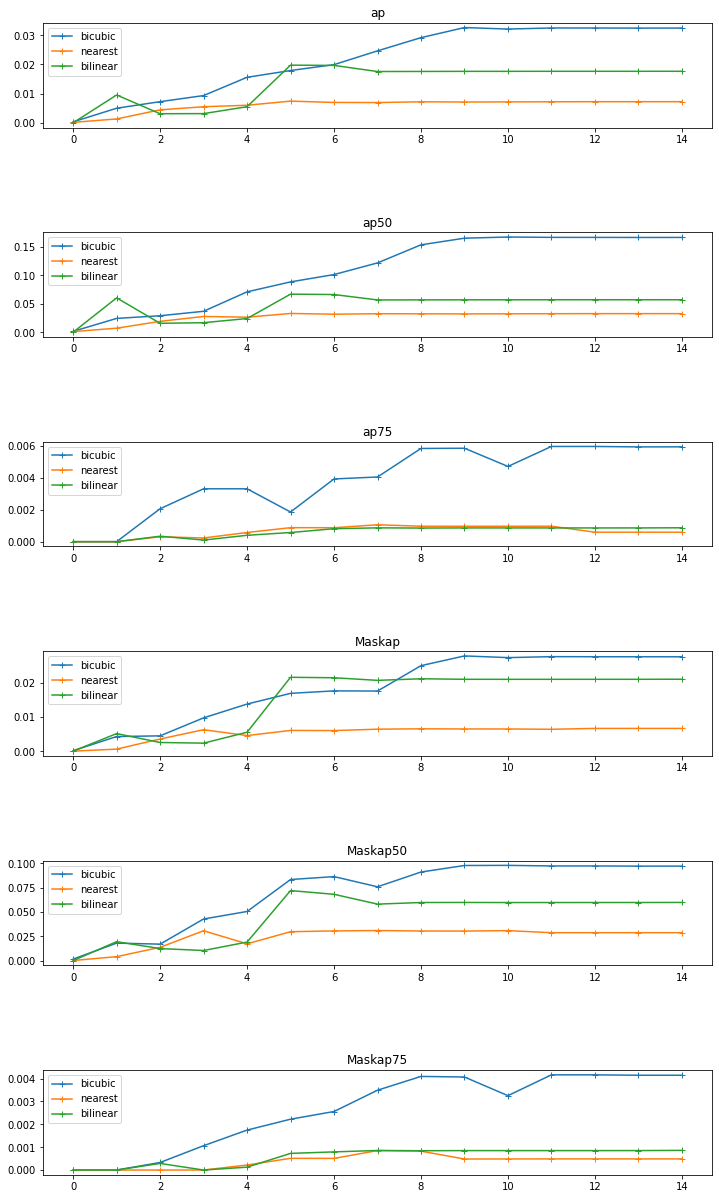

In [4]:
from matplotlib import pyplot as plt
interpols = ['bicubic','nearest','bilinear']
metric_name   = ['ap','ap50','ap75','Maskap','Maskap50','Maskap75']
num_metric    = len(metric_name)
limit     = 15
f, axs = plt.subplots(num_metric, 1, figsize=(12, 20),sharex=False) # w,h

for inter in interpols:
    exec(f'evaluators={inter}_evals')
    
    metrics = dict(zip( metric_name, list( [] for _ in range(len(metric_name))  )  
                      ))

    for evtor in evaluators:
        for iou_type, coco_eval in evtor.coco_eval.items():
            #coco_eval.summarize()
            #  iou_type : 'bbox' ,'segm'
            if iou_type == 'bbox':
                aps = coco_eval.stats[:3]
                metrics['ap'].append(aps[0])
                metrics['ap50'].append(aps[1])
                metrics['ap75'].append(aps[2])

            else : # 'segm'
                aps = coco_eval.stats[:3]
                metrics['Maskap'].append(aps[0])
                metrics['Maskap50'].append(aps[1])
                metrics['Maskap75'].append(aps[2])
    
    metrics_keys = list(metrics.keys() )
    for i,met_name in enumerate(metrics):
        axs[i].set_title(met_name)
        axs[i].plot( metrics[met_name][:limit],'-+',label=inter)
        axs[i].legend()
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=1)
plt.savefig('assets/bln3.jpg')
# plt.subplots(constrained_layout=True)
    #         coco_eval.stats[:3] # ap ,ap0.5 , ap0.75

In [5]:
import pandas as pd
num_epoch = 11
aps = []
for inter in interpols:
    exec(f"bbox = {inter}_evals[num_epoch].coco_eval['bbox'].stats[:3]")
    exec(f"segm = {inter}_evals[num_epoch].coco_eval['segm'].stats[:3]")
    row = bbox.tolist()+segm.tolist()
    aps.append(row)
pd.DataFrame(aps,index=interpols,columns=metric_name)

,ap,ap50,ap75,Maskap,Maskap50,Maskap75
bicubic,0.032478,0.166551,0.005963,0.027694,0.097201,0.004160
nearest,0.007204,0.032603,0.000968,0.006438,0.028716,0.000486
bilinear,0.017642,0.057108,0.000860,0.021060,0.059672,0.000850
